# Market Basket Analysis

### Loading Required Libraries

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import warnings
import collections as col
import itertools as iterto
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
import gensim
from sklearn.cluster import KMeans #for kmeans algorithm
#For dimensionality reduction.
from sklearn.decomposition import PCA #pca from decomposition module.
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition #decomposition module

## Data Loading and Cleaning

### Reading Input Files

In [3]:
aisles = pd.read_csv('https://raw.githubusercontent.com/yashwanthky/Market_Basket_Analysis/Data_Loading/aisles_perishables_tagged.csv', index_col = 0, error_bad_lines = False).reset_index()
departments = pd.read_csv('instacart_2017_05_01/departments.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
orders = pd.read_csv('instacart_2017_05_01/orders.csv')
orders_products_train = pd.read_csv('instacart_2017_05_01/order_products__prior.csv')  # We train the model using this data of n-1 orders
orders_products_test = pd.read_csv('instacart_2017_05_01/order_products__train.csv')   # We validate the predictions with this data of the nth order

In [5]:
aisles.head()

,aisle_id,aisle,Perishables
0,1,prepared soups salads,1
1,2,specialty cheeses,1
2,3,energy granola bars,0
3,4,instant foods,0
4,5,marinades meat preparation,1


### Data Check
#### (shape, features, unique values and missing values)

In [9]:
print ("Rows     : " ,orders.shape[0])
print ("Columns  : " ,orders.shape[1])
print ("\nFeatures : \n" ,orders.columns.tolist())
print ("\nMissing values :  ", orders.isnull().sum().values.sum())
print ("\nMissing values :  ", orders.isnull().sum().values)
print ("\nUnique values :  \n",orders.nunique())

Rows     :  3421083
Columns  :  7

Features : 
 ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

Missing values :   206209

Missing values :   [     0      0      0      0      0      0 206209]

Unique values :  
 order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64


There are 206,209 missing values in the column 'days_since_prior_order'. This means that these orders are the first orders for the 206,209 unique customers

In [10]:
# Let us see the order count by unique user id

print(orders.groupby('user_id').agg({'order_id' : ['count']}).min(),
      orders.groupby('user_id').agg({'order_id' : ['count']}).max(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).mean(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).median(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).std())

order_id  count    4
dtype: int64 order_id  count    100
dtype: int64 order_id  count    16.590367
dtype: float64 order_id  count    10.0
dtype: float64 order_id  count    16.654774
dtype: float64


There are around 10 orders for 75% of the customers and the minimum number of orders per user is 4 and the maximum number of orders per user is 100.

In [11]:
print ("Rows     : " ,orders_products_train.shape[0])
print ("Columns  : " ,orders_products_train.shape[1])
print ("\nFeatures : \n" ,orders_products_train.columns.tolist())
print ("\nMissing values :  ", orders_products_train.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_train.nunique())

Rows     :  32434489
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64


In [12]:
print ("Rows     : " ,orders_products_test.shape[0])
print ("Columns  : " ,orders_products_test.shape[1])
print ("\nFeatures : \n" ,orders_products_test.columns.tolist())
print ("\nMissing values :  ", orders_products_test.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_test.nunique())

Rows     :  1384617
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64


## Data Merging

In [4]:
merged_data = pd.merge(orders_products_train,orders, on = 'order_id')
merged_data = pd.merge(merged_data,products, on = 'product_id')
merged_data = pd.merge(merged_data,aisles, on = 'aisle_id')
merged_data = pd.merge(merged_data,departments, on = 'department_id')

Replacing the missing values in the column 'days_since_prior_order' with '999'

In [5]:
merged_data['days_since_prior_order'].fillna('999',inplace = True)

In [15]:
print ("Rows     : " ,merged_data.shape[0])
print ("Columns  : " ,merged_data.shape[1])

Rows     :  32434489
Columns  :  16

Missing values :   [('order_id', 0), ('product_id', 0), ('add_to_cart_order', 0), ('reordered', 0), ('user_id', 0), ('eval_set', 0), ('order_number', 0), ('order_dow', 0), ('order_hour_of_day', 0), ('days_since_prior_order', 0), ('product_name', 0), ('aisle_id', 0), ('department_id', 0), ('aisle', 0), ('Perishables', 0), ('department', 0)]

Unique values :  
 order_id                  3214874
product_id                  49677
add_to_cart_order             145
reordered                       2
user_id                    206209
eval_set                        1
order_number                   99
order_dow                       7
order_hour_of_day              24
days_since_prior_order         32
product_name                49677
aisle_id                      134
department_id                  21
aisle                         134
Perishables                     2
department                     21
dtype: int64


## Data Preprocessing and Convertion

- Grouping on the level of the User_id and collecting all the product ids together
- Forming sentenses using the names, so that they can be input to the TfidfVectorizer in the rquired format

In [6]:
merged_data_subset = merged_data[['user_id', 'order_id', 'product_name']]

In [17]:
user_level_products_paragraphs = merged_data_subset.groupby(by=['user_id'])['product_name'].apply(list).reset_index(name='order_products')

In [18]:
user_level_products_paragraphs.head()

,user_id,order_products
0,1,"[0% Greek Strained Yogurt, Organic Unsweetened..."
1,2,[Total 2% with Strawberry Lowfat Greek Straine...
2,3,[Unsweetened Chocolate Almond Breeze Almond Mi...
3,4,"[Organic Gala Apples, Organic Large Extra Fanc..."
4,5,"[Large Organic Omega3 Brown Eggs, Plain Whole ..."


Collating all the product ids of a user together into a single list.

In [21]:
def concatenate_list_data(list):
    result= ''
    for element in list:
        result += str(element) + '. '
    return result

user_level_products_paragraphs = user_level_products_paragraphs.apply(lambda x: (x[0], concatenate_list_data(x[1])), axis=1, result_type='expand')

In [23]:
user_level_products_paragraphs.columns = ['user_id', 'product_names']

In [34]:
user_level_products_paragraphs.to_csv("user_level_products_paragraphs.csv", index=False)

Re-runnig below module only during the re-run to reduce the CPU usage

In [6]:
user_level_products_paragraphs = pd.read_csv("user_level_products_paragraphs.csv")

## Tfidftransformer Models 

### Initialize CountVectorizer 

Converting the products list by user dataframe into a list of list

In [7]:
import pandas as pd
 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
docs = user_level_products_paragraphs.product_names.values.tolist()

In [12]:
#instantiate CountVectorizer()
cv=CountVectorizer()
 
# this steps generates word counts for the words in your docs
word_count_vector=cv.fit_transform(docs)

In [13]:
word_count_vector.shape

(206209, 10736)

### Compute the IDF values 

In [14]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [15]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights'])

,idf_weights
organic,1.086614
milk,1.267256
cheese,1.330724
whole,1.385896
free,1.398935
original,1.403701
butter,1.462230
red,1.488155
baby,1.501262
white,1.508412


### Compute the TFIDF score for your documents 

In [16]:
# count matrix
count_vector=cv.transform(docs)
 
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

### Extracting the feature vector for the first user 

In [17]:
feature_names = cv.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
jerky,0.525114
pistachios,0.497555
soda,0.298247
string,0.258651
beef,0.253818
organic,0.188274
original,0.162143
toast,0.150345
pick,0.133086
cola,0.123654


## Tfidfvectorizer Models 

We have used the same data pre-processing module as above

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 500)
 
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [37]:
user_features = pd.DataFrame(tfidf_vectorizer_vectors.todense())
user_features.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.0,0.0,0.000000,0.000000,0.102913,0.0,0.0,0.000000,0.096053,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.027231,0.0,0.185296,0.0
1,0.010181,0.0,0.0,0.063982,0.015400,0.017061,0.0,0.0,0.084994,0.053078,...,0.015449,0.0,0.172133,0.0,0.000000,0.132433,0.325028,0.0,0.000000,0.0
2,0.019477,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.069685,0.487399,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.073593,0.0,0.091105,0.000000,0.000000,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.000000,0.071602,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.125937,0.0,0.000000,0.0


In [38]:
user_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,...,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,0.030609,0.005888,0.012680,0.005161,0.010180,0.008122,0.005071,0.007945,0.016813,0.038099,...,0.009532,0.005741,0.037865,0.006229,0.020804,0.008796,0.057552,0.006319,0.010308,0.009971
std,0.050080,0.026782,0.042233,0.026737,0.029628,0.027062,0.026330,0.043727,0.034985,0.067817,...,0.028384,0.027861,0.051698,0.024016,0.036629,0.048614,0.076596,0.032179,0.048958,0.030029
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.017942,0.000000,0.000000,0.000000,0.027290,0.000000,0.000000,0.000000
75%,0.044291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019794,0.051148,...,0.000000,0.000000,0.057913,0.000000,0.030696,0.000000,0.090639,0.000000,0.000000,0.000000
max,0.614687,0.618171,0.676062,0.864311,0.534681,0.584790,0.947681,1.000000,0.529071,0.715669,...,0.606928,0.837658,1.000000,0.571561,0.567615,0.957950,0.797085,0.736874,0.820080,0.607011


## Customer Segmentation - Clustering Analysis 

Building an elbow curve to get the ideal number of clusters for the analysis 

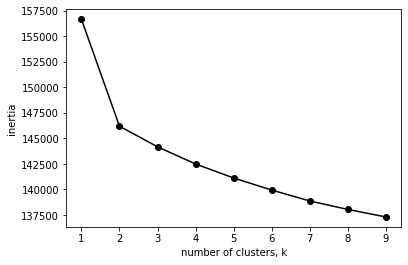

In [41]:
array_cust_features = user_features.values
ks = range(1,10) # Let us vary the number of clusters from 1 to 9
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)    # Create a KMeans instance with k clusters: model
    model.fit(array_cust_features)                    # Fit the k-means model
    inertias.append(model.inertia_) # Append the inertia to the list of inertias
    
plt.plot(ks, inertias, '-o', color='black') # Plotting the elbow curve'.
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## PCA analysis for visualizing the clusters 

### Identifying the components with best variance explained 

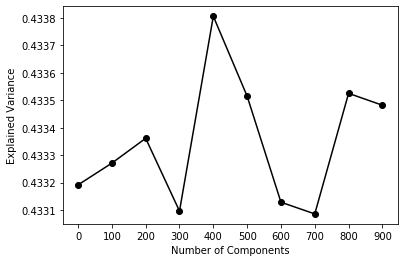

In [45]:
ks = range(0,1000, 100) # Let us vary the number of clusters from 1 to 9
inertias = []
for k in ks:
    pca = decomposition.PCA(n_components=50)
    pca_user_order = pca.fit_transform(array_cust_features)
    inertias.append(pca.explained_variance_ratio_.sum())
    
plt.plot(ks, inertias, '-o', color='black') # Plotting the elbow curve'.
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.xticks(ks)
plt.show()
    

### Building Clustering models with ideal number of clusters 

In [46]:
#Build the model (kmeans using 5 clusters)
kmeans = KMeans(n_clusters=5)
array_cust_aisle_clustered = kmeans.fit_predict(array_cust_features) #fit_predict on chosen components only.

Let us check how many users fall into each of the clusters.

In [50]:
#Checking cluster concentration. 
pd.DataFrame(array_cust_aisle_clustered)[0].value_counts().sort_values(ascending = False)

1    61356
2    52306
4    46223
0    33413
3    12911
Name: 0, dtype: int64